In [2]:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/'

In [3]:
#Import Ruomin's package
from edamame import * 

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from matplotlib import colors
import pandas as pd
import skspatial
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d
import copy


from scipy.io import loadmat, savemat
from scipy import signal

#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace
import matplotlib.colors as clrs


2021-11-12 18:09:24,052:INFO:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [5]:
# GENERATE + LOAD CSV FILE OF IMAGES:
from learning_functions import generate_data, load_data
N= 9
generate_data(N)
inputs,onehot_outputs,sample_num,targets=load_data(N)
target_letters=['z','v','n']
inv_inputs = np.linalg.pinv(inputs)
inputs=inputs[:,:-1]


In [6]:
#SIMPLE ROW INPUTS:

#HERE WE NEED TO CHANGE IT SO THAT EACH SOURCE GETS A ROW OF 5 INPUTS PER EPOCH 
#for example, instead of [1,0,1,0,1,0,0,1,0] representing a 'V' for 3x3, we want:
#[101,010,101] as the inputs.
#scaling to 5x5 would be:

#[10001,01010,01010,00100,00100] - V
#[11111,00010,00100,01000,11111] - Z
#[10001,11001,10101,10011,10001] - N


np.random.seed(42)
numSamples=10
orig_inputs=np.array((np.array([1,0,1,1,0,1,0]),np.array([0,1,0,1,1,0,1])))
orig_inputs=orig_inputs.astype('double')
samples=[[] for i in range(len(orig_inputs))]
new_inputs=np.array([orig_inputs]*numSamples)

#Pattern without Noise
NoNoiseInputs=[]
for targetClass in range(len(orig_inputs)):
    NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])

#Make Noisy variants of simple patterns:
for i in range(len(orig_inputs)):
    for j in range(numSamples):
        randVals=np.random.randint(1,3) #choose how many of the 3 sources will have noise
        noiseVals=np.random.randint(3, size=randVals)
        temp=orig_inputs[i][orig_inputs[i]==1].astype('double')
        for val in noiseVals:
            temp[val]=np.double(np.random.random(1))
        new_inputs[j][i][new_inputs[j][i]==1]=temp
#         samples[i].append(temp)

#RESHAPE INPUTS INTO 10x3
row1=[]
row2=[]
for i in range(len(new_inputs)):
    row1.append(new_inputs[i][0])
    row2.append(new_inputs[i][1])

inputs=np.array([row1,row2])
inputs=inputs.reshape(20,orig_inputs.shape[1])
targets=np.zeros(20)
targets[-10:]=1

In [7]:
#change 0 volts to 0.05
minVoltage=0.005
#Paramater 1 = baseline input voltages
inputs=inputs+minVoltage
#instead of +ve bias, make it negative

In [8]:
inputs.shape

(20, 7)

In [9]:
from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph

In [10]:
pwd

'/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/Natesh_3x3'

In [11]:
#load SPARSE network
#Not you need this file in a folder called Sparse Networks 
# asn_nw_00300_nj_00621_seed_1252_avl_10.00_disp_01.00_lx_100.00_ly_100.00
#asn_nw_00350_nj_01400_seed_2665_avl_10.00_disp_01.00_lx_50.00_ly_50.00
#asn_nw_00250_nj_00794_seed_134_avl_10.00_disp_01.00_lx_50.00_ly_50.00
# nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00')
nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_01399_nj_06084_seed_1159_avl_10.00_disp_01.00_lx_100.00_ly_100.00')
this_seed=8639#np.random.randint(10000) #random seed
Network=nw#edamame.core.generate_network(300,dispersion=350,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

In [12]:
#fixing file structure from Matlab:
connectivity.avg_length=connectivity.avg_length[0][0]
connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
connectivity.dispersion=connectivity.dispersion[0][0]
# connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
connectivity.length_x=connectivity.length_x[0][0]
connectivity.length_y=connectivity.length_y[0][0]
connectivity.number_of_wires=connectivity.number_of_wires[0][0]
connectivity.numOfWires=connectivity.numOfWires[0][0]
connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
connectivity.theta=connectivity.theta[0][0]
connectivity.this_seed=connectivity.this_seed[0][0]

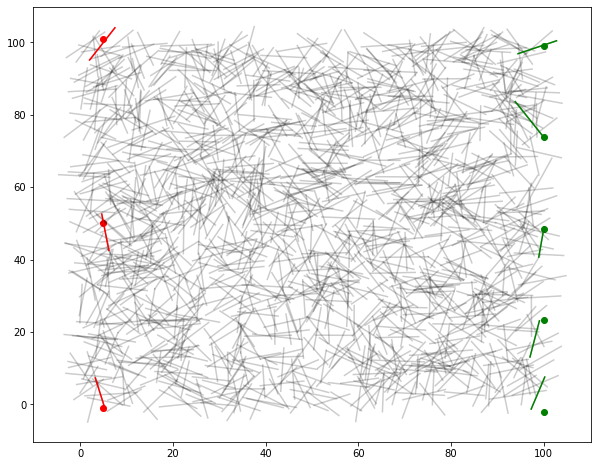

In [13]:
#Generate Network
%matplotlib inline

#find x and y values of each end of each wire 
xa=connectivity.xa[0]
xb=connectivity.xb[0]
ya=connectivity.ya[0]
yb=connectivity.yb[0]

#Pick Electrode placement/distance apart:

#DRAINS
numDrains=3
ex=np.ones(numDrains)*5#*15
# ey=np.linspace(0,550,numDrains)
ey=np.linspace(-1,101,numDrains)#(-1,101,numDrains)

elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

plt.figure(figsize=(10,8))
plt.scatter(ex, ey, c = 'r')

#SOURCES
numSources=5 # FOR 5x5 we will use 5 inputs and each input will get a row of information (5inputs of 5rows = 5x5 image)

#IN A LINE:
ex=np.ones(numSources)*100#50
ey=np.linspace(-2,99,numSources)#(-2,99,numSources)
#IN A 3X3 GRID:
# middleNWx=int(connectivity.length_x/2)+1
# middleNWy=int(connectivity.length_y/2)-1
# distBwElecs=10
# ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
# ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')

# plt.savefig(figLoc+'Network and Electrodes.png',dpi=300)

In [14]:
print('OG Sources:' + str(elecSource))
print('OG Drains:' + str(elecDrain))


#remove middle drain and sources for simple patterns:

# elecSource=elecSource[[0,1,2,4,6,7,8]]
elecDrain=elecDrain[[0,-1]]

OG Sources:[ 901 1013  860  872  317]
OG Drains:[134 659 251]


In [14]:
#MANUAL SOURCES DRAINS IF THERE'S OVERLAP
# elecSource=[23,320,26,74,145,317,129,247,141] #elecSource=[39,253,155,33,271,25,185,163,256]
# elecDrain=[296,249,25]#elecDrain=[306,317,53]

In [15]:
# #PLOT GRAPH REPRESENTATION:
# plt.figure(figsize=(12,12))
# pos=nx.kamada_kawai_layout(nx.from_numpy_array(connectivity.adj_matrix))
# nx.draw(nx.from_numpy_array(connectivity.adj_matrix),pos=pos,with_labels=True)
# nx.draw_networkx_nodes(elecSource,node_color='g',pos=pos)
# nx.draw_networkx_nodes(elecDrain,node_color='r',pos=pos)

In [15]:
from learning_functions import calc_cost,setupStimulus,setupSourcesOnly,runTesting,getNWState,calcOutputs


In [16]:
#This function changes the write voltage of the drain electrodes. This is where we tune the system so that 
#it prioritises/de-prioritises certain pathways based on targets and non-targets
def change_voltage(stim,sim2,outputVals,target_index,th=0,th2=0,signalType='DC'):
    import copy
    stimulus=copy.deepcopy(stim)
    
    Vi        = np.zeros((int(run_time/dt)))
    maxV      = onAmp*0.75
    n         = len(outputVals)
    cost      = np.zeros(n)
    beta      = 0.1 #change the values here
    grad      = np.zeros((n))
    dsig    = np.array([stimulus[i].signal for i in range(len(stimulus))][:num_drain_training])
    
    #vectorised implementation
    cost=calc_cost(outputVals,target_values) 
    
#     if gradOff == False: #
    grad=beta*(outputVals-target_values) 
#     elif gradOff == True: #if we have hit currents target
#         grad=0
    dsig2=dsig.T+(grad*onAmp)
    for i in range(n): # for each drain:
        if stimulus[i].signal[0] <= maxV and stimulus[i].signal[0] >= -maxV:
            stimulus[i].signal=dsig2.T[i]
        
    print('Costs '+str(cost))
    print('Sum Cost '+str((np.sum(cost))))
    print('Gradients '+str(grad))
    return outputVals,stimulus,cost

In [17]:
#ADD BACKPROP
#This function runs each training epoch and saves the network state at the last timestep of that epoch   
def getNWState_backprop(training_stimulus,state,drains,sources,run_time=2,dt=0.01,disable_tqdm=False):
    eles = np.append(drains, sources) #all drains
    #     if len(eles) == num_drain_training + num_source_training:
    training_sim,cost = runSim_backprop(connectivity, 
                       stimulus = training_stimulus,
                       junctionMode = 'tunneling',
                       dt = dt, T = run_time, 
                       contactMode = 'preSet',
                       electrodes = eles,
                       findFirst = False,
                       start_state = state,
                       disable_tqdm=disable_tqdm,
                       criticalFlux=0.1)  
    #     JS1 = getJunctionState(training_sim, -1) #save state
    #     else: 
    #         print('Bless you Joel :)')
    return training_sim,cost   

In [18]:
#Combine drain voltage change with runSim:
def runSim_backprop(Connectivity, 
                    junctionMode='binary', collapse=False,
                    criticalFlux=0.1, maxFlux=1.5e-1,
                    contactMode='farthest', electrodes=None,
                    dt=1e-3, T=10, 
                    stimulus = None,
                    biasType = 'DC',
                    onTime=0, offTime=50000000,
                    onAmp=1, offAmp=0.005,
                    f = 1, customSignal = None,
                    start_state = None,
                    lite_mode = False, save_steps = 1,
                    findFirst = True,
                    disable_tqdm = False,
                    freeze_wire = None, freeze_junction = None, 
                    freeze_TimeStamp = None):

    """
    For the case of multi electrodes, stimulus should be in parameters.
    See help(stimulus__) for how to generate stimulus__ objects.
    """

    SimulationOptions = simulationOptions__(dt = dt, T = T,
                                            connectivity = Connectivity, 
                                            contactMode = contactMode,
                                            electrodes = electrodes)

    if ((contactMode == 'preSet') and (len(electrodes) > 2)) or stimulus is not None:
        from sys import exit
        if stimulus == None:
            logging.warning(f'Multiple electrodes detected. Please input stimulus in parameters!')
            exit()
        if len(stimulus) < len(SimulationOptions.electrodes):
            diff = len(SimulationOptions.electrodes) - len(stimulus)
            for _ in range(diff):
                stimulus.append(stimulus__('Drain', T = T, dt = dt))

        if len(stimulus) > len(SimulationOptions.electrodes):
            logging.warning(f'More stimulus than electrodes. Current setup has {len(SimulationOptions.electrodes)} electrodes!')
            exit()
            
        if len(stimulus[0].signal) < len(SimulationOptions.TimeVector):
            logging.warning(f'Stimulus length not correct, current time vector has length {len(SimulationOptions.TimeVector)}!')
            exit()
        SimulationOptions.stimulus = stimulus
            
    elif contactMode == 'boundary':
        SimulationOptions.stimulus[:int(len(SimulationOptions.electrodes)/2)] = [stimulus__(biasType = biasType, 
                                                                                        T = T, dt = dt,
                                                                                        onTime = onTime, offTime = offTime,
                                                                                        onAmp = onAmp, offAmp = offAmp,
                                                                                        f = f, customSignal= customSignal)
                                                                                        for i in range(int(len(SimulationOptions.electrodes)/2))]
    else:
        SimulationOptions.stimulus[0] = stimulus__(biasType = biasType, 
                                                T = T, dt = dt,
                                                onTime = onTime, offTime = offTime,
                                                onAmp = onAmp, offAmp = offAmp,
                                                    f = f, customSignal= customSignal)
    if start_state == None: 
        JunctionState = junctionState__(Connectivity.numOfJunctions, 
                                    mode = junctionMode, collapse = collapse, 
                                    criticalFlux=criticalFlux, maxFlux = maxFlux)
    else:
        from copy import deepcopy
        JunctionState = deepcopy(start_state)
    
    kwdict = dict()
    if (freeze_wire != None) or (freeze_junction != None):
        kwdict = dict(freeze_wire = freeze_wire,
                    freeze_junction = freeze_junction, 
                    freeze_TimeStamp = freeze_TimeStamp)
        
    this_realization,cost = simulateNetwork_backprop(SimulationOptions, Connectivity, JunctionState, lite_mode, disable_tqdm, save_steps, **kwdict)
    
    if findFirst:
        from edamame.analysis.GraphTheory import findCurrent
        try:
            activation = findCurrent(this_realization, 1)
            logging.info(f'First current path {activation[0][0]} formed at time = {activation[1][0]} s.')
        except:
            logging.info('Unfortunately, no current path is formed in simulation time.')

    return this_realization,cost   



In [19]:
def simulateNetwork_backprop(simulationOptions, connectivity, junctionState, lite_mode = False, disable_tqdm = False, save_steps = 1, **kwargs):
    niterations = simulationOptions.NumOfIterations
    electrodes = simulationOptions.electrodes
    numOfElectrodes = len(electrodes)
    E = connectivity.numOfJunctions
    V = connectivity.numOfWires
    edgeList = connectivity.edge_list
    
    maxV      = onAmp
    n         = num_drain_training #num of drains
    cost      = []
    beta      = 1
    grad      = np.zeros((n)) #set gradients to zero for each epoch  

    Network = network__()
    sampling = np.arange(0, niterations, save_steps)
    if lite_mode:
        Network.connectivity = connectivity__(adjMat = connectivity.adj_matrix)
        Network.filamentState = np.zeros((int(niterations/save_steps), E))
        Network.wireVoltage = np.zeros((int(niterations/save_steps), V))
        Network.electrodeCurrent = np.zeros((int(niterations/save_steps), numOfElectrodes))
        Network.TimeVector = np.zeros(int(niterations/save_steps))
    else:        
        Network.connectivity = connectivity
        Network.TimeVector = simulationOptions.TimeVector
        Network.filamentState = np.zeros((niterations, E))
        Network.junctionVoltage = np.zeros((niterations, E))
        # Network.junctionResistance = np.zeros((niterations, E))
        Network.junctionConductance = np.zeros((niterations, E))
        Network.junctionSwitch = np.zeros((niterations, E), dtype = bool)
        Network.wireVoltage = np.zeros((niterations, V))
        Network.electrodeCurrent = np.zeros((niterations, numOfElectrodes))

    Network.sources = []
    Network.drains = []
    for i in range(numOfElectrodes):
        if np.mean(simulationOptions.stimulus[i].signal) != 0:
            Network.sources.append(electrodes[i])
        else:
            Network.drains.append(electrodes[i])

    if len(Network.drains) == 0:
        Network.drains.append(electrodes[1])

    if 'freeze_wire' in kwargs:
        freeze_wire = kwargs['freeze_wire']
        freeze_TimeStamp = kwargs['freeze_TimeStamp']
    else:
        freeze_TimeStamp = niterations + 1
    
    #Simulation Run:
    new_time=0
    for this_time in tqdm(range(niterations), desc='Running Simulation ', disable = disable_tqdm): #each time step
        
        this_stimulus = np.array([i.signal[this_time] for i in simulationOptions.stimulus])
        
        if this_time == 0:
            print('--------')
            print('Training')
            print('--------\n')
        elif this_time == trainTime:
            print('--------')
            print('Testing')
            print('--------\n')    
        
        if this_time > 0 and this_time < trainTime: #if we are training, change drain voltages, otherwise just use this_stimulus
            this_stimulus[:num_drain_training]=new_stimulus 
            
#             print('in training '+str(this_time))
#         elif this_time > trainTime:
            
        sol = simCore(connectivity, junctionState, this_stimulus, electrodes, simulationOptions.dt)

        if this_time >= freeze_TimeStamp:
            others = np.setdiff1d(range(V), freeze_wire)
            wireVoltage[others] = sol[others]
        else:
            wireVoltage = sol[0:V]
            
        if lite_mode:
            if this_time%save_steps == 0:
                Network.wireVoltage[this_time//save_steps,:] = wireVoltage
                Network.electrodeCurrent[this_time//save_steps,:] = sol[V:]
                Network.filamentState[this_time//save_steps,:] = junctionState.filamentState
                Network.TimeVector[this_time//save_steps] = simulationOptions.TimeVector[this_time]
        else:
            Network.wireVoltage[this_time,:] = wireVoltage
            Network.electrodeCurrent[this_time,:] = sol[V:]
            Network.filamentState[this_time,:] = junctionState.filamentState
            Network.junctionVoltage[this_time,:] = junctionState.voltage
            Network.junctionConductance[this_time,:] = junctionState.conductance
            Network.junctionSwitch[this_time,:] = junctionState.OnOrOff
        
        ## BackProp Implementation
        y = Network.electrodeCurrent[this_time,:num_drain_training]
        
        if tmpTargets[this_time] != -1: #skip rest values
            tarIdx=tmpTargets[this_time]
            y = y/(maxCurrent[tarIdx]) # normalize  | | | how do we change max current to be not arbitrary? 
            
        # current method - run simulation before with just that drain and use current as maxCurrent

            # change to threshold 
            d = allTargets[tarIdx]
            dsig = this_stimulus[:num_drain_training]


            #vectorised implementation
            cost.append(calc_cost(y,d))

            if this_time < trainTime: #if we are training, update beta
                #Gradient without considering other electrodes:
        # 
                grad=beta*(y-d) #e.g. [y1 vs (d1 = 1), y2 vs (d2 = 0), y3vs (d3 = 0)]
                #Gradient while considering other electrodes:
        #         for i in range(n): #for each drain 
                    #y = normalised drain current
                    #d = target (1 or 0) e.g. [1,0,0]

        #             grad[i] = beta*(y[i]-d[i]) + sum([beta*(y[j]-d[j]) for j in range(n) if j != i])
                    # i = 1, drain 1 is target, target = 1
                    # i = 2, drain 2 is target, target = 0

                #grad_i = (y_i - d_i) + SUM[ beta*(y_j - d_j) ], j \neq (doesn't equal) i        
                dsig2=np.array(dsig.T+(grad*onAmp))

                dsig2[tmpTargets[this_time]]=0
                new_stimulus=dsig2

                for q in range(n): # for each drain:
                    if dsig2[q] <= maxV and dsig2[q] >= -maxV:
                        new_stimulus[q]=dsig2[q]
                    elif dsig2[q] < -maxV:
                        new_stimulus[q]=-maxV
                    elif dsig2[q] > maxV:
                        new_stimulus[q]=maxV  

                tmp=range(0,niterations,numDT)
                if this_time in tmp:
                    print('Target ' +str(d))
                    print('Drain V '+str(dsig2))
            else:
                tmp=range(0,niterations,numDT)
                if this_time in tmp:
                    print('Signal ' + str(this_stimulus))
                    print('Target ' +str(d))
                    print('Cost: ' +str(cost[new_time]))
            new_time+=1
            
    Network.numOfWires = V
    Network.numOfJunctions = E
    Network.electrodes = simulationOptions.electrodes
    if len(electrodes) <= 2:
        Network.conductance = Network.electrodeCurrent[:,1]/simulationOptions.stimulus[0].signal[sampling]
    if not lite_mode:
        Network.stimulus = [simulationOptions.stimulus[i] for i in range(numOfElectrodes)]
        Network.junctionResistance = 1/Network.junctionConductance
        
    return Network,cost



In [20]:
sources = elecSource
drain_pool = elecDrain
allTargets=[[1,0],[0,1]]#[[1,0,0],[0,1,0],[0,0,1]]#onehot_outputs#


Num Pixels per class:4
Num Overlapping Pixels: 4
Sample Sequence: 1221
Num Timesteps per Sample: 300
Length Rest bw Samples: 0



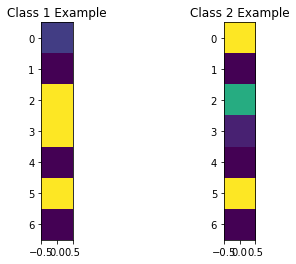

In [24]:
#Parameter Sweep:

#Parameter 1: Number of source electrodes per class (complexity of pattern)
fig,axes = plt.subplots(1,2)
axes[0].set_title('Class 1 Example')
axes[1].set_title('Class 2 Example')
axes[0].imshow(trainingInputs[0].reshape(-1,1))
axes[1].imshow(trainingInputs[-1].reshape(-1,1))
print('Num Pixels per class:' + str(np.sum(trainingInputs[0]>minVoltage)))

#Parameter 2: Amount of overlap between classes
overlap = np.sum(trainingInputs[0]==trainingInputs[-1])
print('Num Overlapping Pixels: ' + str(overlap))

#Parameter 3: Temporal Sequence
sequences = [1122,2211,1221,2112,1212,2121]
this_seq  = 2

if sequences[this_seq] == 1122:
    order = range(len(inputs))
elif sequences[this_seq] == 2211:
    order = np.hstack((range(8,12),range(12,16),range(0,4),range(4,8),range(16,20)))
elif sequences[this_seq] == 1221:
    order = np.hstack((range(0,4),range(8,16),range(4,8),range(16,20)))
elif sequences[this_seq] == 2112:
    order = np.hstack((range(8,12),range(0,8),range(12,16),range(16,20)))
elif sequences[this_seq] == 2121:
    order = np.hstack((range(8,12),range(0,4),range(12,16),range(4,8),range(16,20)))
elif sequences[this_seq] == 1212:
    order = np.hstack((range(0,4),range(8,12),range(4,8),range(12,16),range(16,20)))
print('Sample Sequence: ' + str(sequences[this_seq]))
    
#Parameter 4: Input Voltage (onAmp)
allAmpsTraining = [0.5,1,2,5] #Input voltage training
allAmpsTesting  = [0.1,0.2,0.3,0.5] #Input voltage testing
onAmp = allAmpsTraining[2]
onAmpTest = allAmpsTesting[3]


#Parameter 5: Number of timesteps per sample + delta timesteps
dt      = 0.002
numDT   = 300 #number of timesteps per sample
print('Num Timesteps per Sample: ' + str(numDT))

#Parameter 6: rest between samples
rest    = [0]*N
restDur = 0 #number of rest timesteps between samples
print('Length Rest bw Samples: ' + str(restDur))

#Parameter 7: b-value (collapse value)
#this is changed in simSettings.py (edamame/core)

In [25]:
#Associative Learning to find max currents for each drain:
numClasses=2
numTestingPerClass=2
#Parameter 2 = Voltage
signalType='DC'
run_time=1

num_drain_training=1
num_source_training=len(elecSource)
t=[None]*numClasses
sim=[None]*numClasses
currentPaths=[None]*numClasses
state=[None]*numClasses
numTrainingSamples=8
rest=[0]*num_source_training
restDur=0
trainOrder=np.array(range(numTrainingSamples))
np.random.shuffle(trainOrder)

for classNum in tqdm(range(numClasses)):
    targetClass   = classNum #'z','v','n'
    target_values = allTargets[targetClass]
    chosenDrain   = drain_pool[targetClass]
    
    targetClassVals=[0,1]
#     target_values=np.hstack((target_values,0)) #add extra 0 for 4th drain that acts just to balance the network

    trainingInputs  = inputs[targets==targetClassVals[targetClass]][:-numTestingPerClass]
    testingInputs   = inputs[targets==targetClassVals[targetClass]][-numTestingPerClass:]
    
    #expand each value to run the number of timesteps:
    newRow=np.zeros((len(trainingInputs),int(run_time/dt)+restDur,num_source_training))
    count=0
    for i in trainingInputs[trainOrder]:
        for j in range(int(run_time/dt)+restDur):
            if j < int(run_time/dt):
                newRow[count][j]=i
            else:
                newRow[count][j]=rest
        count=count+1
    stimulus=np.concatenate(newRow,axis=0).T*onAmp

    newSignal=[]
    for i in range(num_drain_training):
        newSignal.append(stimulus__(biasType='Drain',T=dt*stimulus.shape[1],dt=dt))
    for i in range(len(stimulus)):
        newSignal.append(stimulus__(biasType='Custom',onAmp=onAmp,T=dt*stimulus.shape[1],dt=dt,customSignal=stimulus[i]))
#     set_trace()
    sim[classNum] = getNWState(newSignal,connectivity,None,[chosenDrain],sources,dt=dt,run_time=len(newSignal[0].signal)*dt)

    #CALC TIME AT WHICH PATH FORMS TO USE AS TIME-PER SAMPLE
    # = Parameter 3
#     currentPaths[classNum]=findCurrent(sim[classNum][0])

Running Simulation : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [10:16<00:00,  6.49it/s]


In [26]:
#find max current:
maxDrain1=np.max(sim[0][0].electrodeCurrent.T[0])
maxDrain2=np.max(sim[1][0].electrodeCurrent.T[0])
# maxDrain3=np.max(sim[2][0].electrodeCurrent.T[0])

In [27]:
#loop through classes and set inputs
#,inputs[targets==targetClassVals[2]][:-numTestingPerClass]])

trainingInputs  = np.array([inputs[targets==targetClassVals[0]][:-numTestingPerClass],inputs[targets==targetClassVals[1]][:-numTestingPerClass]]).reshape(-1,orig_inputs.shape[1])
testingInputs   = np.array([inputs[targets==targetClassVals[0]][-numTestingPerClass:],inputs[targets==targetClassVals[1]][-numTestingPerClass:]]).reshape(-1,orig_inputs.shape[1])

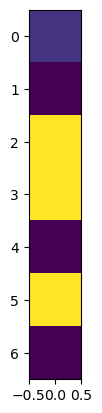

In [28]:
plt.rcParams.update(plt.rcParamsDefault)

plt.imshow(trainingInputs[1].reshape(-1,1))

In [29]:
#How many times we want to show each sample:
traininglabels=np.zeros(len(trainingInputs))
traininglabels[:int(len(trainingInputs)/2)]=0
traininglabels[int(len(trainingInputs)/2):int(len(trainingInputs)/2)*2]=1
# traininglabels[int(len(trainingInputs)/3)*2:]=2
traininglabels=traininglabels.astype(int)

testinglabels=np.zeros(len(testingInputs))
testinglabels[:int(len(testingInputs)/2)]=0
testinglabels[int(len(testingInputs)/2):int(len(testingInputs)/2)*2]=1
# testinglabels[int(len(testingInputs)/3)*2:]=2
testinglabels=testinglabels.astype(int)



#range(len(inputs))
# order=np.matrix(np.zeros((len(inputs),1)))
# perm=np.matrix(np.random.permutation(len(inputs)))
# order+=perm.T
# order=np.array(order.reshape(-1))[0].astype(int)


In [30]:

#HERE WE NEED TO CHANGE IT SO THAT EACH SOURCE GETS A ROW OF 5 INPUTS PER EPOCH 


#Associative Learning with all training samples + backprop

print('Voltage Training: ' + str(onAmp)+'V')
print('Voltage Testing: ' + str(onAmpTest)+'V')

N                   = orig_inputs.shape[1]
maxCurrent          = [maxDrain1,maxDrain2]#,maxDrain3]
numClasses          = 2#3
signalType          ='DC'
num_drain_training  = 2#3
num_source_training = N
t                   = [None]*len(order)
tmpSources          = [[] for i in range(len(order))]
tmpTargets          = [None]*len(order)
sim                 = [None]*len(order)
numTrainingSamples  = len(trainingInputs)
numTestingSamples   = len(testingInputs)

#Simulation Times
trainTime  = numTrainingSamples*(numDT+restDur)
testTime   = numTestingSamples*(numDT+restDur)

#Randomise classes:
i=0
for val in order: #this method loops through samples

    if val < numTrainingSamples:
        this_sample = trainingInputs[val] #xs
        this_label  = traininglabels[val] #ys
    else:
        ii = val - numTrainingSamples
        this_sample = testingInputs[ii] #xs
        this_label  = testinglabels[ii] #ys
        
    targetClassVals=[0,1,2] 

    targetTmp = signal_expand(this_label,numDT) #number of timesteps per target
#     #array of nans:
    tmpArray=np.empty(restDur)
    tmpArray[:]=-1
    targetTmp = np.append(targetTmp,tmpArray) #add rest #need to remove targets from rest
    tmpTargets[i]=targetTmp 

    for j in range(len(this_sample)): #for each source electrode
        tmp = signal_expand(this_sample[j],numDT)
        tmp = np.append(tmp,np.zeros(restDur)) #add rest
        tmpSources[i].append(tmp)
    i += 1
    
#reshape stimulus[i] into 1d:
tmpSources = np.hstack(np.array(tmpSources))
tmpTargets = np.hstack(np.array(tmpTargets)).astype(int)

# Change voltages
newSources=tmpSources.copy()

for src in range(len(newSources)):
    a=newSources[src][:trainTime][newSources[src][:trainTime]>0.005]
    b=newSources[src][trainTime:][newSources[src][trainTime:]>0.005]
    newSources[src][:trainTime][newSources[src][:trainTime]>0.005]=onAmp*a
    newSources[src][trainTime:][newSources[src][trainTime:]>0.005]=onAmpTest*b

tmpDrain=[]
stimulus=[]
for j in range(num_drain_training): #create stimulus for each drain electrode
    stimulus.append(stimulus__(biasType='Drain',T=dt*len(newSources[j]),dt=dt))
    
for j in range(len(tmpSources)): #create stimulus for each source electrode
    stimulus.append(stimulus__(biasType='Custom',T=dt*len(newSources[j]),dt=dt,customSignal=newSources[j]))

# set_trace()
signalLen=len(stimulus[0].signal) 

#Run simulation
sim,cost = getNWState_backprop(stimulus,None,drain_pool,sources,run_time=int(signalLen*dt),dt=dt,disable_tqdm=False)
#Calculate electrode currents
t,v = calcOutputs(sim,sources,drain_pool)
    
#if we want only one drain, use [chosenDrain] instead of drain_pool


Voltage Training: 2V
Voltage Testing: 0.5V


--------
Training
--------

Target [1, 0]
Drain V [0.         0.00147186]
Target [1, 0]
Drain V [0.         0.38293437]
Target [1, 0]
Drain V [0.         0.62586209]
Target [1, 0]
Drain V [0.         0.70245054]
Target [0, 1]
Drain V [0.48998731 0.        ]
Target [0, 1]
Drain V [1.07685868 0.        ]
Target [0, 1]
Drain V [1.06394418 0.        ]
Target [0, 1]
Drain V [0.98695717 0.        ]
Target [0, 1]
Drain V [0.77927746 0.        ]
Target [0, 1]
Drain V [0.867665 0.      ]
Target [0, 1]
Drain V [0.66030325 0.        ]
Target [0, 1]
Drain V [0.90027406 0.        ]
Target [1, 0]
Drain V [0.        1.7428108]
Target [1, 0]
Drain V [0.         1.01710025]
Target [1, 0]
Drain V [0.         0.47466206]
Target [1, 0]
Drain V [0.         0.29708016]
--------
Testing
--------

Signal [0.         0.         0.30627243 0.005      0.5025     0.02572521
 0.005      0.5025     0.005     ]
Target [1, 0]
Cost: [0.39960904 0.00533763]
Signal [0.        0.        0.0350258 0.005     0.5025    0.50

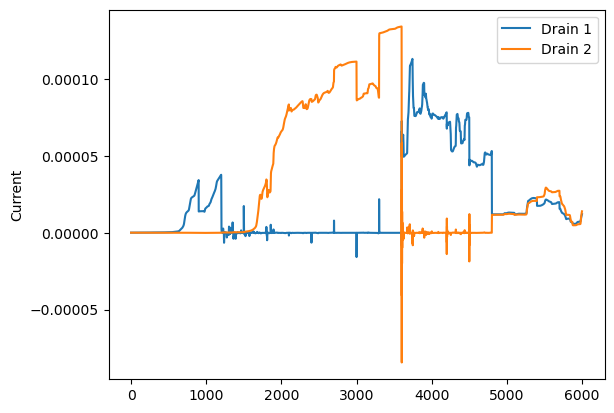

In [34]:
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(t[0])
plt.plot(t[1])
# plt.plot(t[2])
plt.legend(['Drain 1','Drain 2'])#,'Drain 3'])
plt.ylabel('Current')
# plt.vlines((trainTime),-2e-5,6e-5,color='k',linestyles='--')
# plt.vlines((trainTime+(testTime/2)),-2e-5,6e-5,color='k',linestyles='--')
# plt.vlines((trainTime+testTime),-2e-5,6e-5,color='k',linestyles='--')

# plt.ylim([0,2e-5])

# print(labels)
plt.savefig(saveFig+'2 classes_'+str(onAmp)+'V_testing '+str(onAmpTest)+'V_overlap pattern '+str(sequences[this_seq])+'_beta 01_b2_current.png')

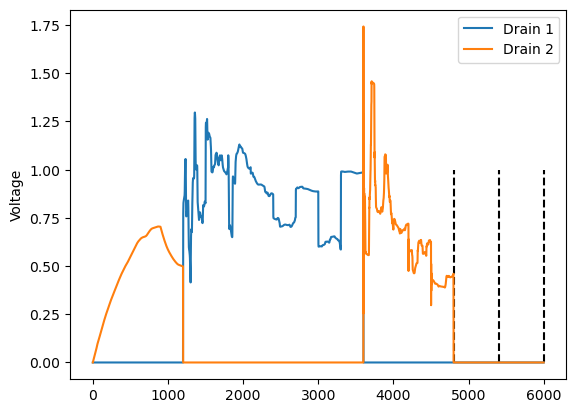

In [36]:
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(sim.wireVoltage[:,drain_pool[0]])
plt.plot(sim.wireVoltage[:,drain_pool[1]])

# plt.plot(t[2])
plt.legend(['Drain 1','Drain 2'])#,'Drain 3'])
plt.ylabel('Voltage')
plt.vlines((trainTime),0,1,color='k',linestyles='--')
plt.vlines((trainTime+(testTime/2)),0,1,color='k',linestyles='--')
plt.vlines((trainTime+testTime),0,1,color='k',linestyles='--')

# plt.xlim([36000,45000])

# print(labels)
plt.savefig(saveFig+'2 classes_'+str(onAmp)+'V_testing '+str(onAmpTest)+'V_overlap pattern '+str(sequences[this_seq])+'_beta 01_b2_Voltage.png')

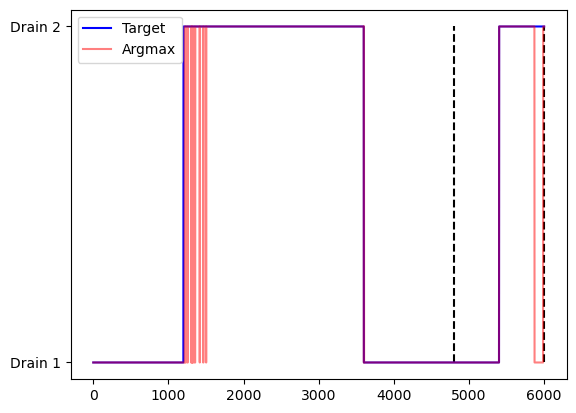

In [37]:
plt.plot(tmpTargets,c='b')
plt.plot(np.argmax([t[0],t[1]],axis=0),alpha=0.5,c='r')
plt.legend(['Target','Argmax'])
plt.vlines((trainTime),0,1,color='k',linestyles='--')
# plt.vlines((trainTime+(testTime/2)),0,1,color='k',linestyles='--')
plt.vlines((trainTime+testTime),0,1,color='k',linestyles='--')
plt.yticks([0,1])
ax=plt.gca()
ax.set_yticklabels(['Drain 1','Drain 2'])
plt.savefig(saveFig+'2 classes_'+str(onAmp)+'V_testing '+str(onAmpTest)+'V_overlap pattern '+str(sequences[this_seq])+'_beta 01_b2_argmax vs target.png')

In [216]:
np.sum(np.argmax([t[0],t[1]],axis=0)[trainTime:]==tmpTargets[trainTime:])/len(tmpTargets[trainTime:])

0.9033333333333333

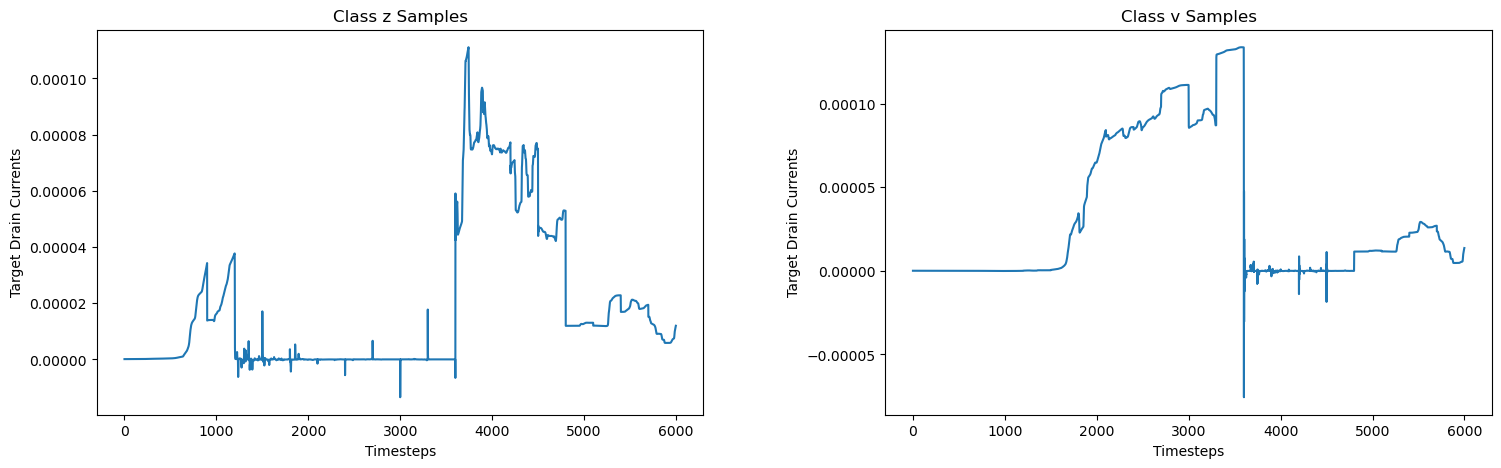

In [222]:
#non-target drains
plt.rcParams.update(plt.rcParamsDefault)

fig,axes=plt.subplots(1,2,figsize=(18,5))
fig.subplots_adjust(wspace=0.3)
i=0
colors=['r','b','g']
for ax in axes.flat:
    tmp=targetClassVals[i]
    ax.plot(sim.electrodeCurrent[:,tmp])
#     ax.legend(np.setdiff1d(target_letters,target_letters[i]))    
    ax.set_title('Class ' +target_letters[i]+' Samples')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Target Drain Currents')
#     ax.vlines(range(0,881,110),0,onAmp+0.05,linestyles='dashed',colors='k',alpha=0.5)
#     ax.set_ylim([-7e-5,3e-4])
#     ax.set_xlim([17000,20000])
    i+=1

In [223]:
readOutElecs=np.random.choice(len(connectivity.adj_matrix), size=6, replace=False)
if any(x in drain_pool for x in readOutElecs):
    print('Drains are in the randomly chosen elecs')
if any(x in sources for x in readOutElecs):
    print('Sources are in the randomly chosen elecs')

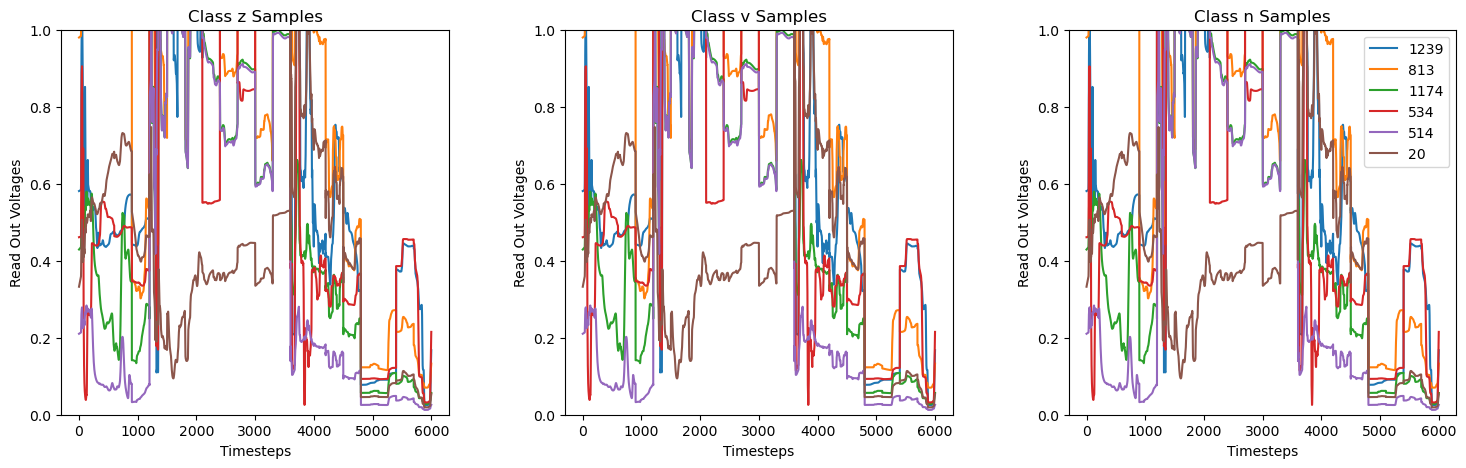

In [224]:
plt.rcParams.update(plt.rcParamsDefault)

fig,axes=plt.subplots(1,3,figsize=(18,5))
fig.subplots_adjust(wspace=0.3)
i=0
for ax in axes.flat:
    ax.plot(sim.wireVoltage[:,readOutElecs])
    plt.legend(readOutElecs)    
    ax.set_title('Class ' +target_letters[i]+' Samples')
#     ax.annotate('Target Drain :' +str(i+1),[0.7,0.1],xycoords='axes fraction')
#     ax.legend(['Drain 1','Drain 2','Drain 3'])
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Read Out Voltages')
#     ax.vlines(range(0,881,110),0,onAmp+0.05,linestyles='dashed',colors='k',alpha=0.5)
    ax.set_ylim([0,1])
    i+=1

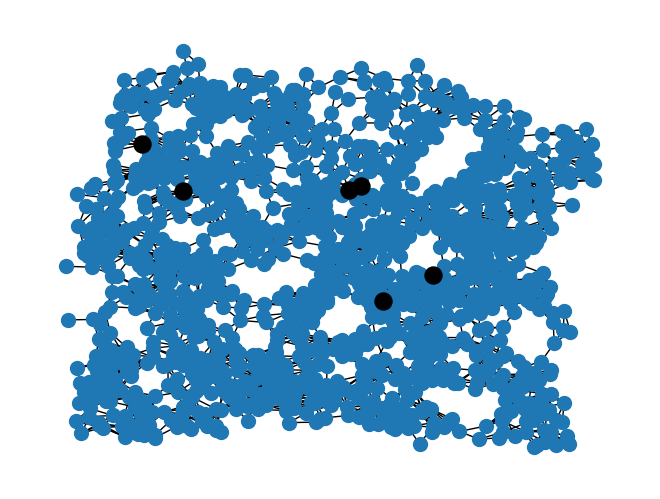

In [351]:
G=nx.from_numpy_array(connectivity.adj_matrix)
pos=nx.kamada_kawai_layout(G)
nx.draw(G,pos=pos,node_size=100)
nodes=nx.draw_networkx_nodes(G,pos=pos,nodelist=readOutElecs,node_color='k',cmap=plt.cm.inferno,node_size=150)

 ...]

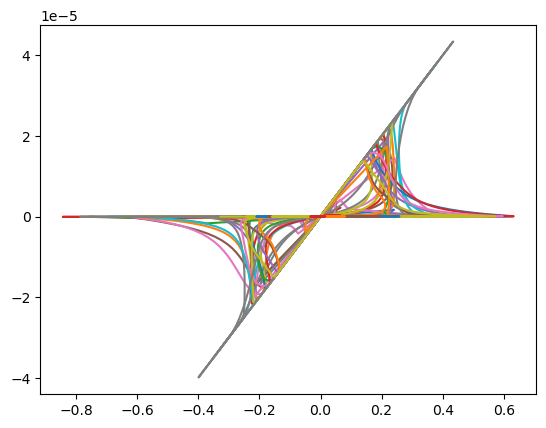

In [216]:
#IV Curves:
plt.plot(sim.junctionVoltage,sim.junctionVoltage/sim.junctionResistance)

### VIDEOS

In [33]:
#Voltage
def image_draw_voltage(time):
    plt.rcParams.update(plt.rcParamsDefault)
    if time == 0:
        sys.stdout.flush()
        sys.stdout.write("\b" * (signalLen+1)) # return to start of line, after '['
    sys.stdout.write('\r'+str(np.around((time/signalLen)*100,2))+'%')
    sys.stdout.flush()
    
    this_TimeStamp=time
    
    data=sim.wireVoltage[this_TimeStamp,:]
    G=nx.from_numpy_array(connectivity.adj_matrix)
    pos=nx.kamada_kawai_layout(G)
    nodes=nx.draw_networkx_nodes(G,pos=pos,node_color=data,cmap=plt.cm.inferno,node_size=150,ax=ax)
    edges=nx.draw_networkx_edges(G,pos=pos,ax=ax)

    # add the bar
#     cbar = plt.colorbar(nodes,label='Voltage',shrink=0.7)


    for i in range(len(sources)):
        x,y=pos[sources[i]]
        ax.text(x+0.1,y,s='Source',size=10, bbox=dict(facecolor='green', alpha=0.3),horizontalalignment='center')

    for i in range(len(drain_pool)):
        x,y=pos[drain_pool[i]]
        ax.text(x-0.1,y,s='Drain',size=10, bbox=dict(facecolor='red', alpha=0.5),horizontalalignment='center')


In [36]:
def image_draw_current_filament(edge_mode,time):
    if time == 0:
        sys.stdout.flush()
        sys.stdout.write("\b" * (signalLen+1)) # return to start of line, after '['
    sys.stdout.write('\r'+str(np.around((time/signalLen)*100,2))+'%')
    sys.stdout.flush()

    G=nx.from_numpy_array(connectivity.adj_matrix)
    pos=nx.kamada_kawai_layout(G)
    draw_graph(sim,time,edge_mode=edge_mode,edge_dashed=True,edge_colorbar=False,node_size=30,edge_cmap=plt.cm.inferno,with_labels=False,figsize=(10, 8),ax=ax)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=drain_pool,node_color='r',node_size=50,ax=ax)

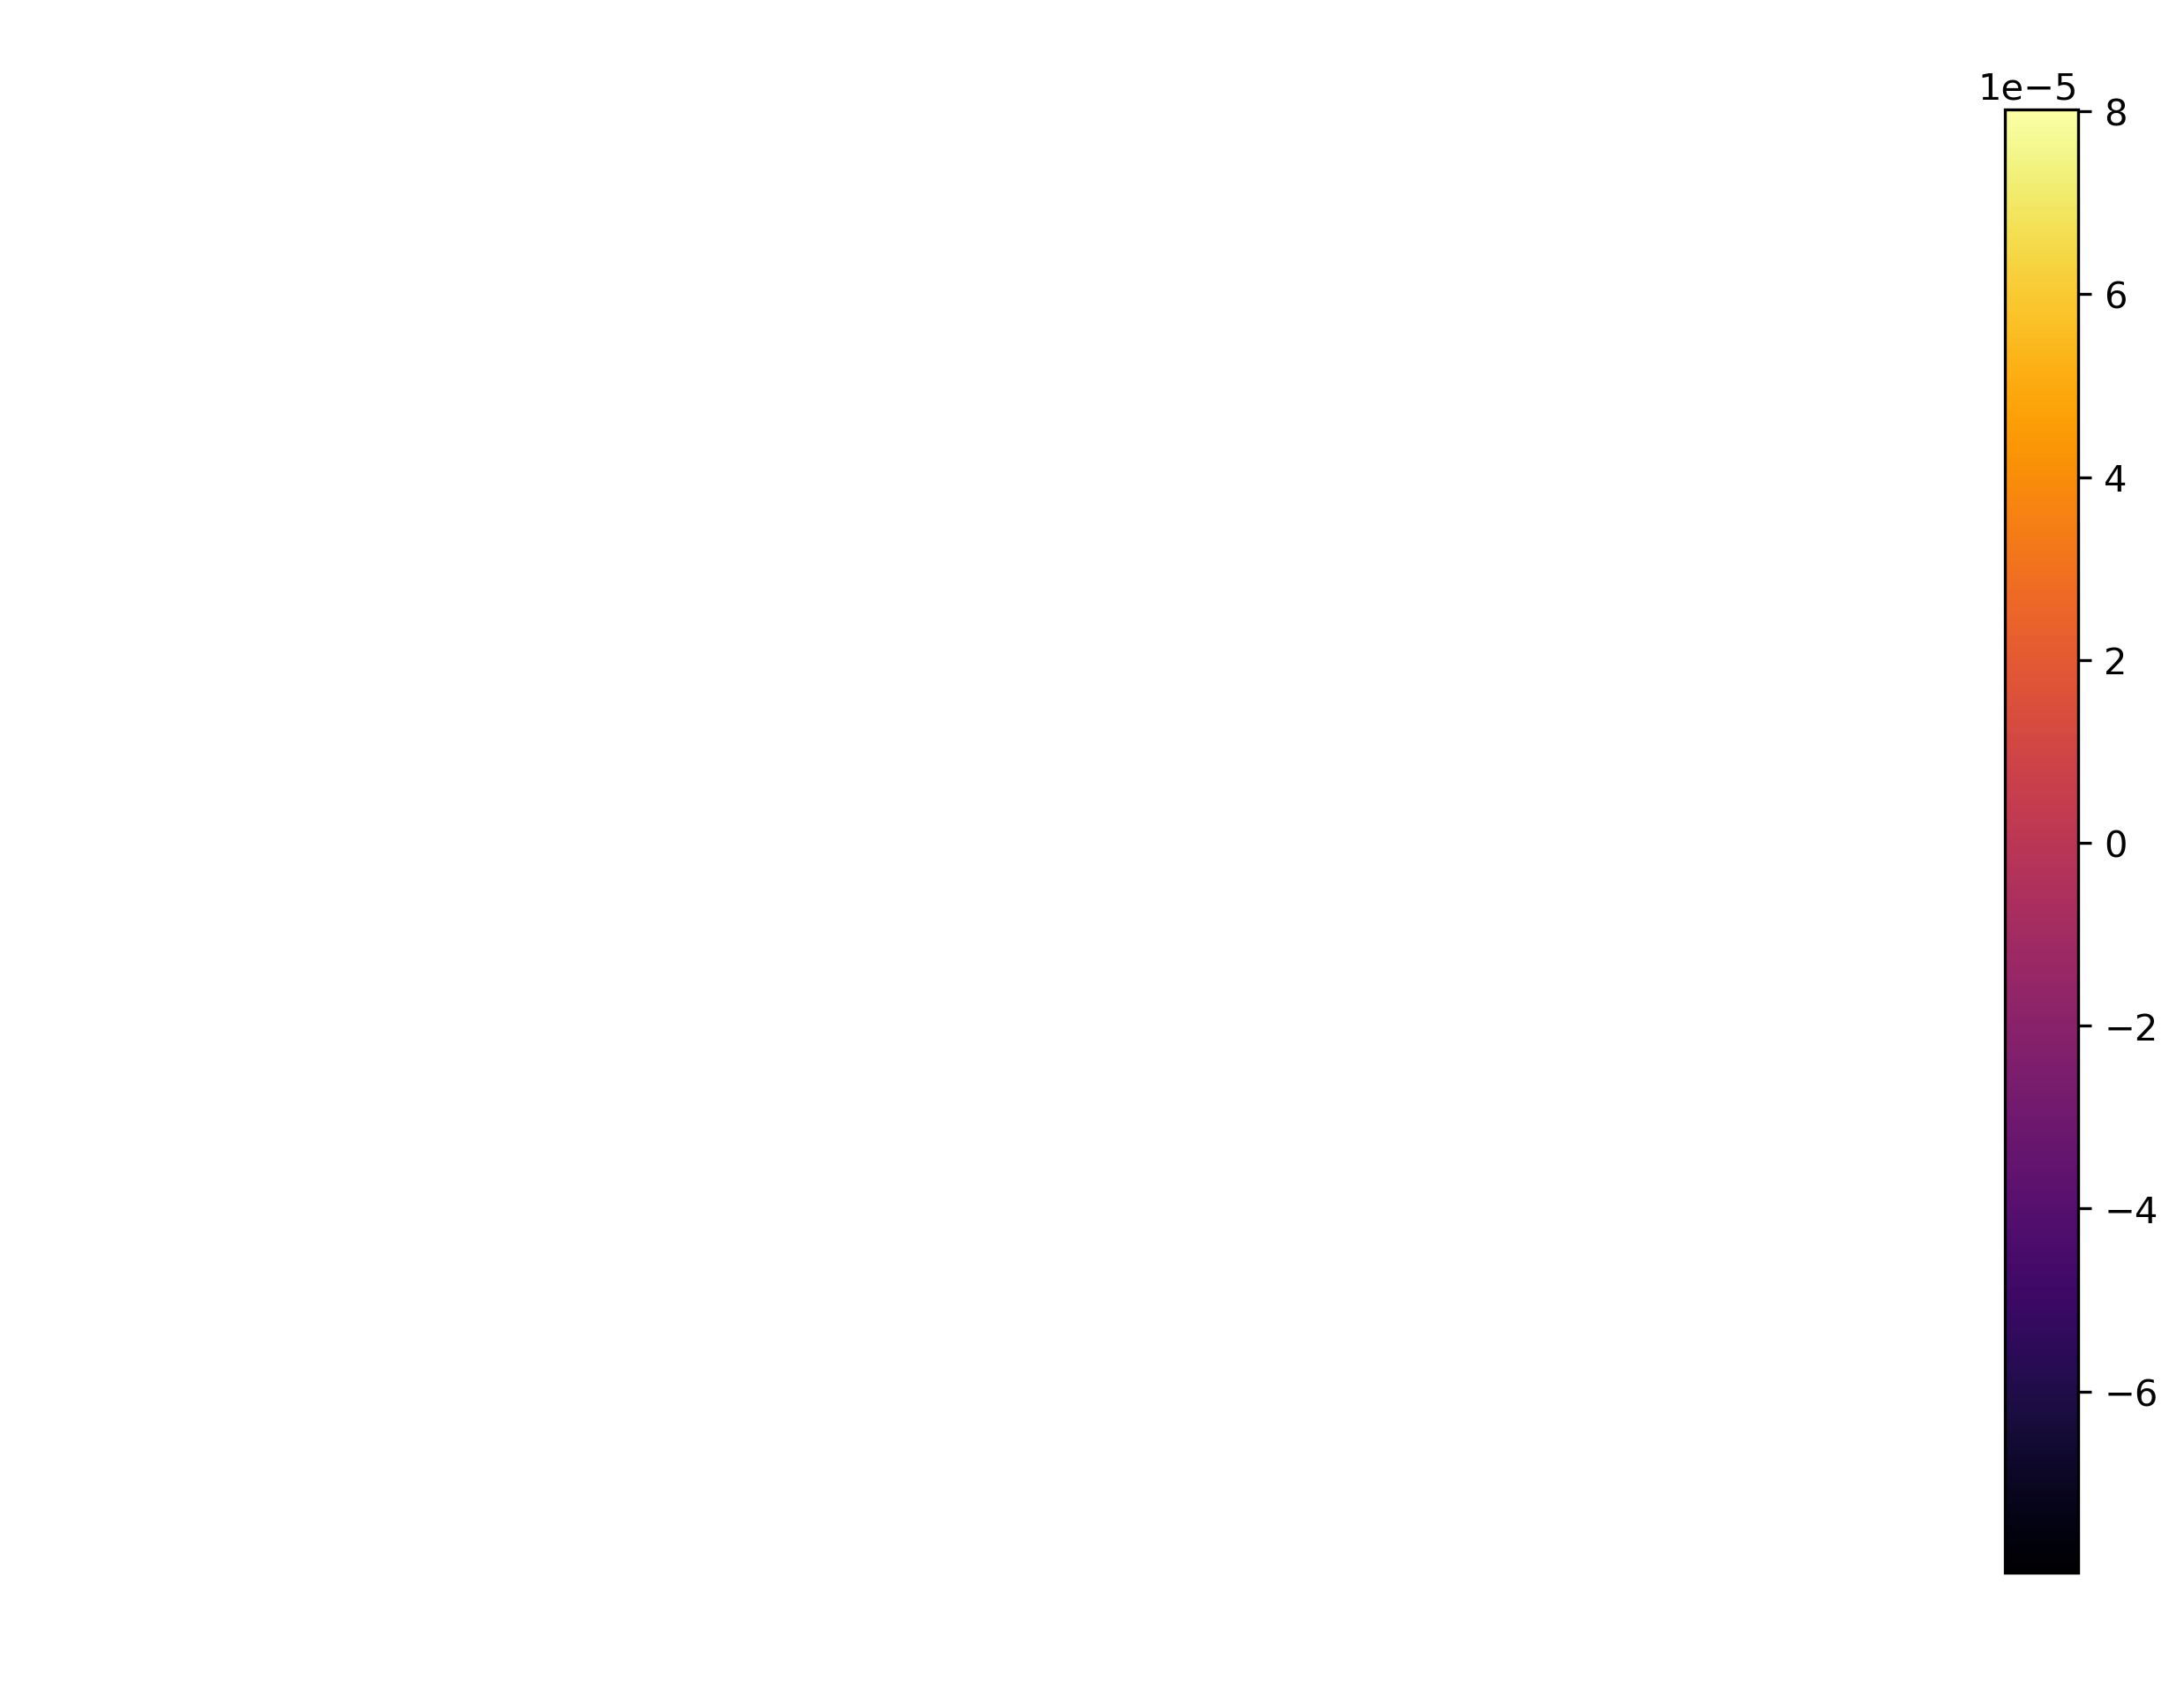

In [31]:
from matplotlib import animation
from PIL import Image
def animateVoltage(time): #animate
    image_draw_voltage(time)
   
def animateCurrentFilament(time,edge_mode='current',): #animate
    image_draw_current_filament(edge_mode,time)

animationType = 'current'

f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)
canvas_width, canvas_height = f.canvas.get_width_height()
ax.axis('off')
cax.axis('off')

if animationType=='voltage':
    minWeights=np.min(sim.wireVoltage)
    maxWeights=np.max(sim.wireVoltage)
elif animationType=='current':
    minWeights=np.min(sim.junctionVoltage/sim.junctionResistance)
    maxWeights=np.max(sim.junctionVoltage/sim.junctionResistance)
else:
    minWeights=np.min(sim.junctionSwitch)
    maxWeights=np.max(sim.junctionSwitch)
#This is a dirty work around for a colorbar
clrplt=np.linspace(minWeights,maxWeights,2).reshape(2,1)
img=cax.imshow(clrplt,cmap=plt.cm.inferno)
cax.set_visible(False)
plt.colorbar(img,ax=cax,cmap=plt.cm.inferno,fraction=2, pad=0.04)

#voltage
if animationType=='voltage':
    anim = animation.FuncAnimation(f, animateVoltage, frames=range(signalLen)[::100], interval=100, repeat=False)
    #current
elif animationType=='current': 
    anim = animation.FuncAnimation(f, animateCurrentFilament, frames=range(signalLen)[::100], interval=100, repeat=False,fargs=('current',))
#filament
else:
    anim = animation.FuncAnimation(f, animateCurrentFilament, frames=range(signalLen)[::100], interval=100, repeat=False,fargs=('filament',))


In [32]:
cd '/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity/'


/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity


In [ ]:
from matplotlib import rcParams
rcParams['animation.embed_limit'] = 2**64

#MP4
FFwriter = animation.FFMpegWriter()
anim.save('Current_Vid_Backprop.mp4', fps=10)

#GIF
# anim.save(saveFig+'Voltage_Vid_Backprop.gif', writer=animation.PillowWriter(fps=30))

#HTML
# s=anim.to_jshtml(fps=30)
# with open(saveFig+'Voltage_Vid_Backprop.html', "w") as img:
#     img.write(s)

2021-11-02 20:50:32,255:INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-11-02 20:50:32,259:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3000x2400 -pix_fmt rgba -r 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y Current_Vid_Backprop.mp4


0.0%

0.0%

22.0%%

In [147]:
cd '/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/Natesh_3x3/'

/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/Natesh_3x3


88.33%

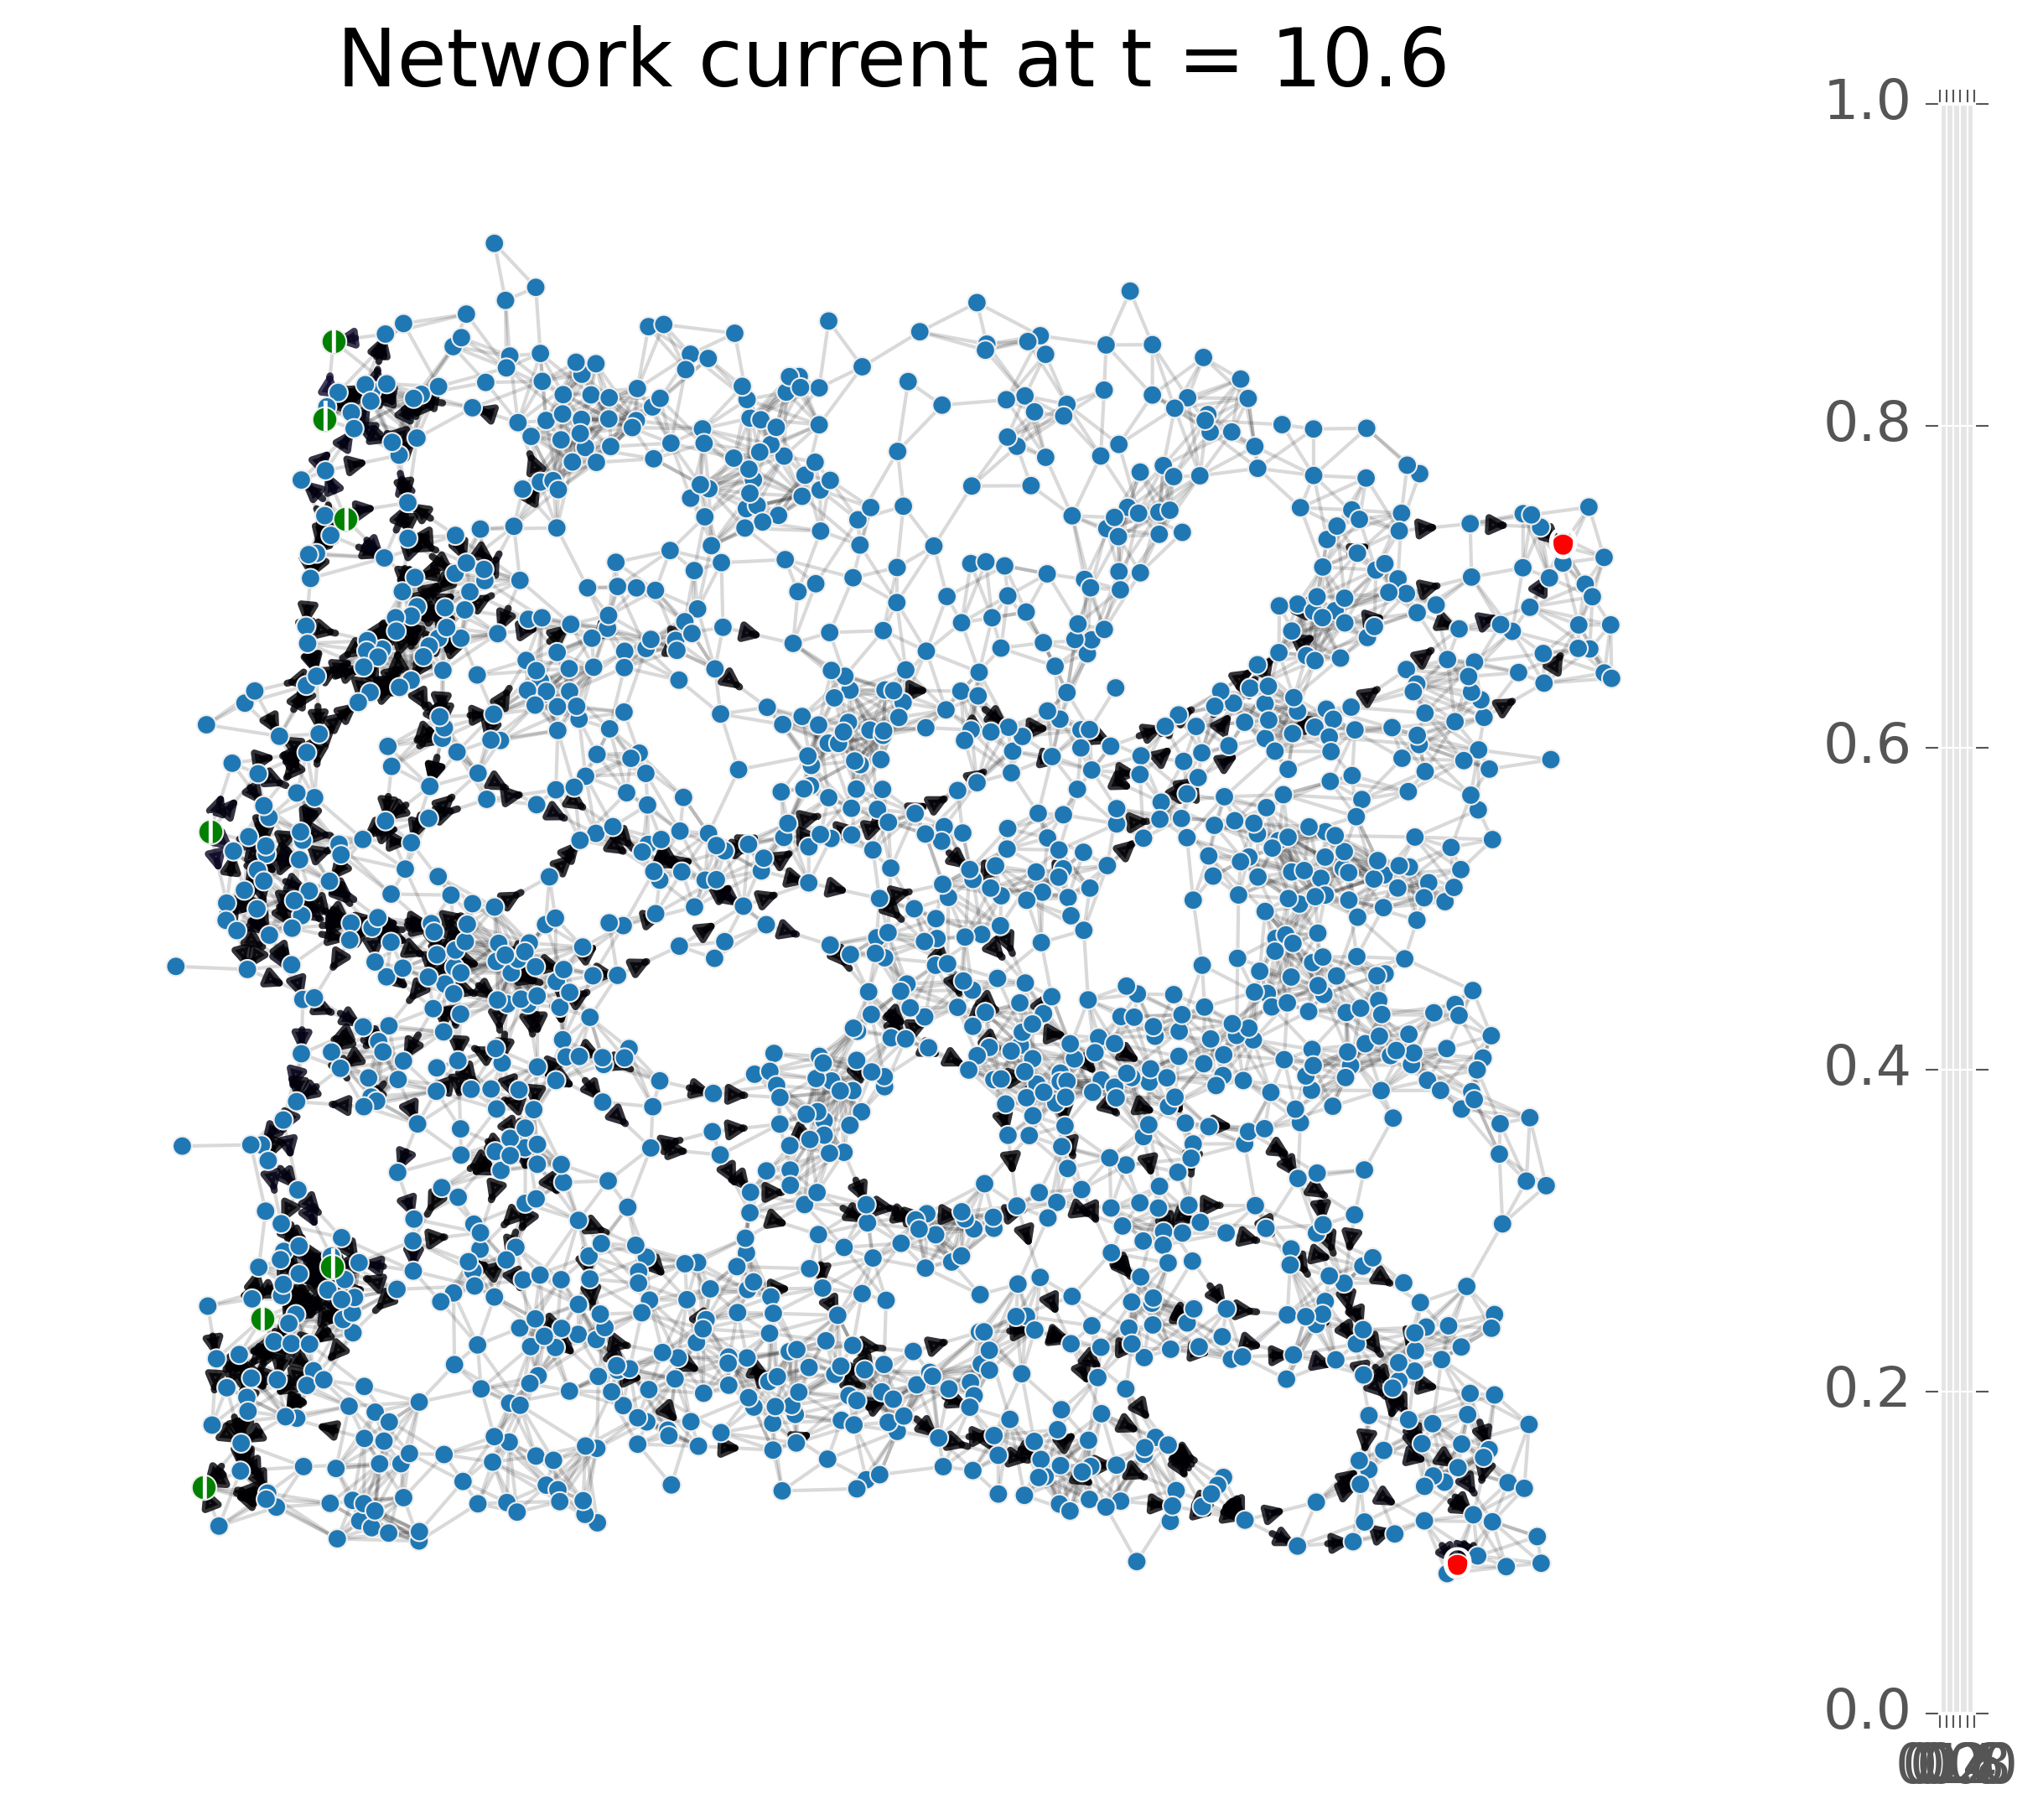

In [37]:
f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)

image_draw_current_filament('current',5300)

75.0%

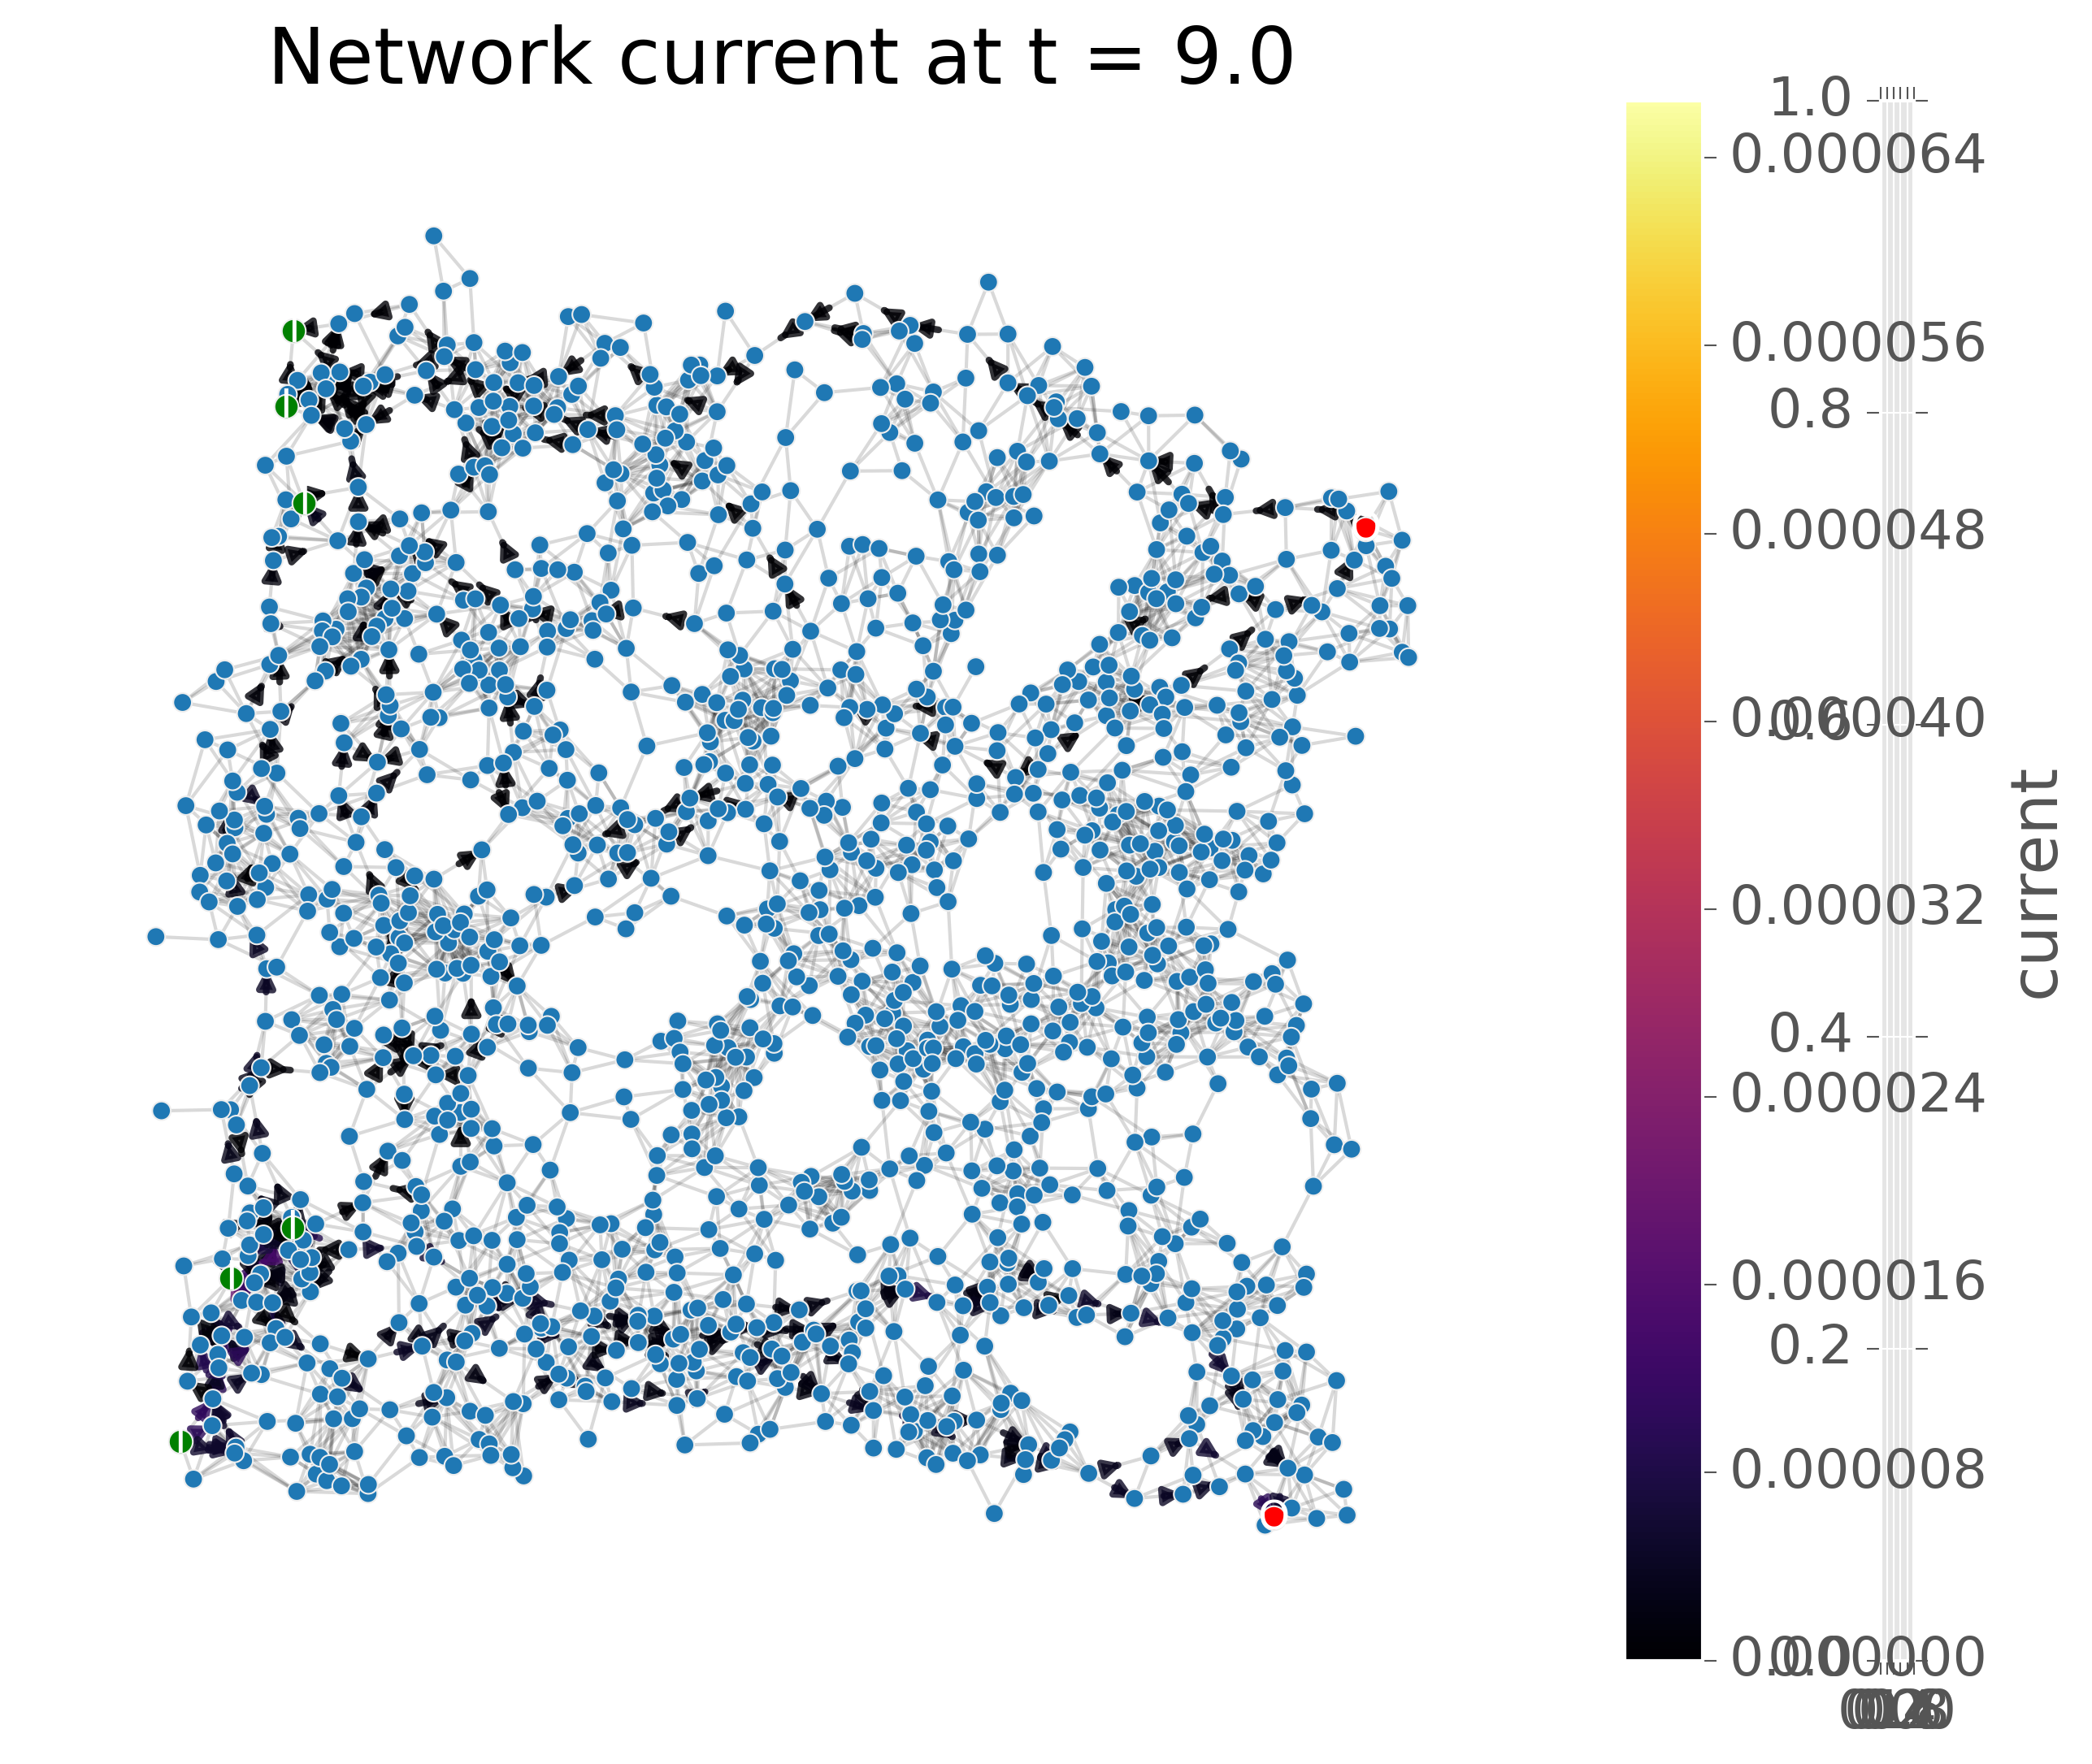

In [248]:
f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)

image_draw_current_filament('current',4500)

83.33%

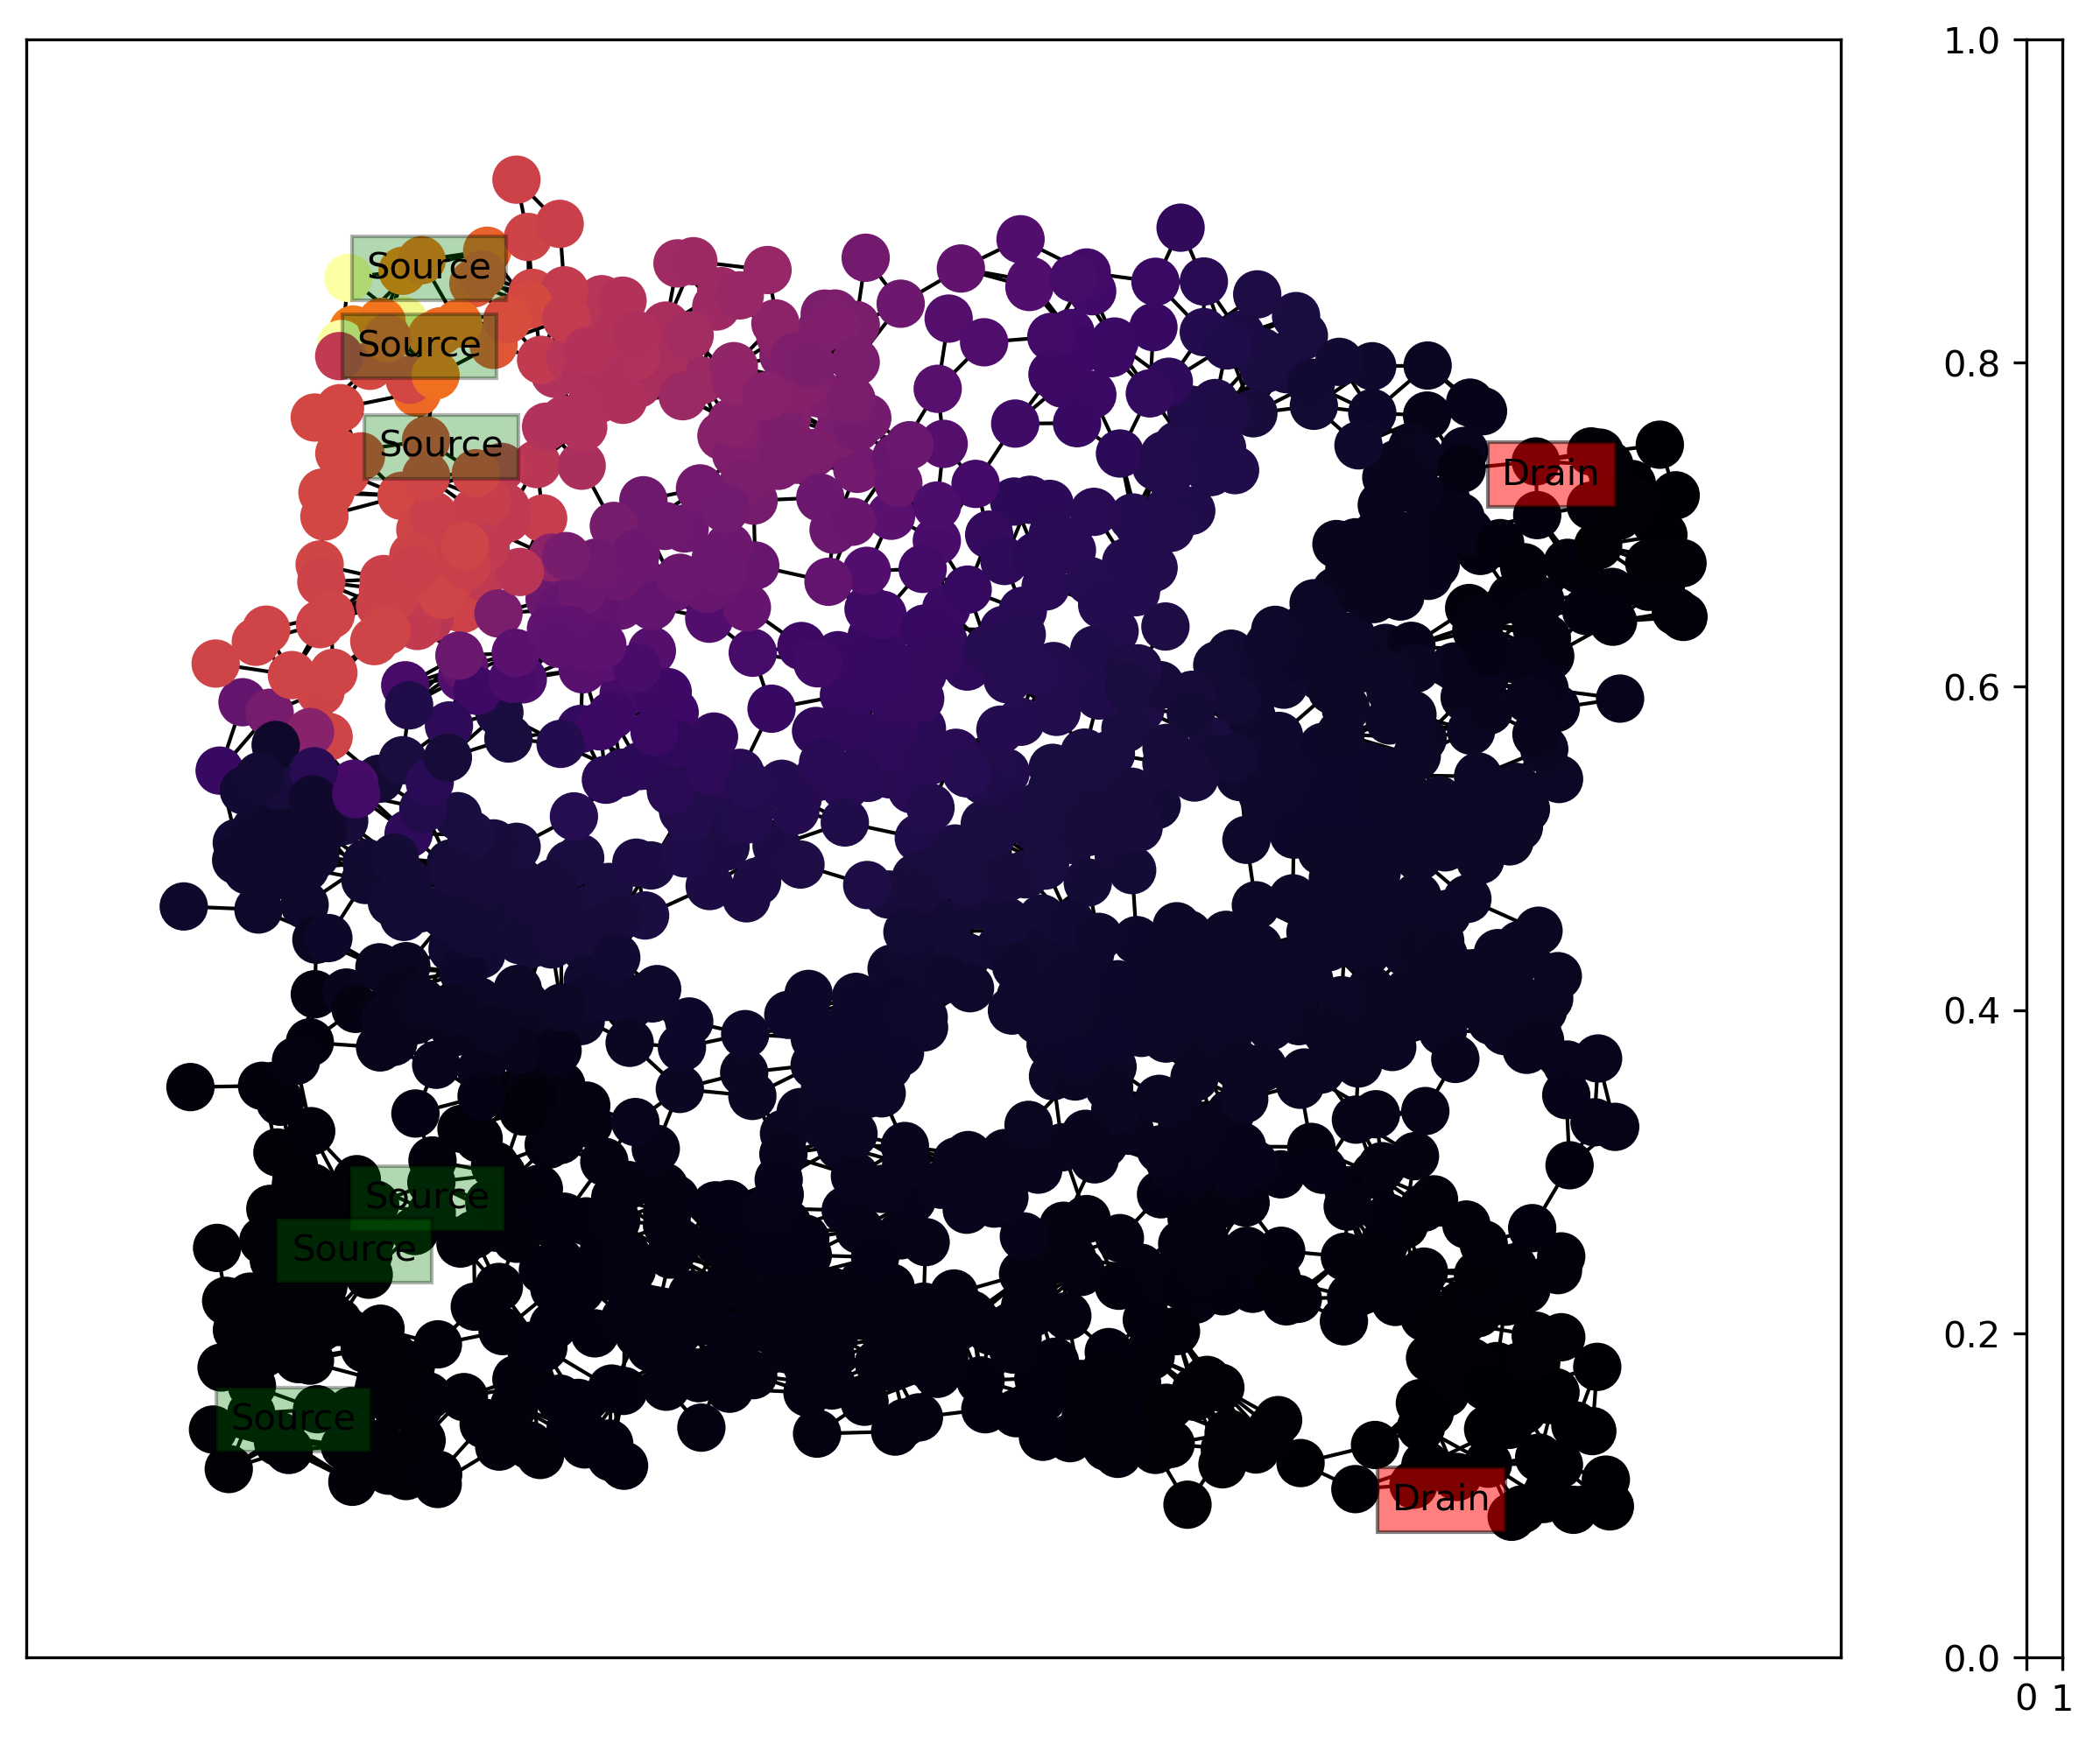

In [226]:
f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)

image_draw_voltage(5000)

In [69]:
# #Current
# this_TimeStamp=7990

# fig=plt.figure(figsize=(10,8))

# data=sim.junctionVoltage[this_TimeStamp,:]/sim.junctionResistance[this_TimeStamp,:]
# nodes=nx.draw_networkx_nodes(G,pos=pos,node_size=30)
# nodes=nx.draw_networkx_nodes(G,pos=pos,nodelist=drain_pool,node_color='r',node_size=30)
# nodes=nx.draw_networkx_nodes(G,pos=pos,nodelist=sources,node_color='g',node_size=30)

# edges=nx.draw_networkx_edges(G,pos=pos,edge_color=data,edge_cmap=plt.cm.RdBu_r,node_size=10)

# # cbnorm = clrs.SymLogNorm(1,1,vmin = min(data), vmax = max(data))
# # cbnorm._transform_vmin_vmax()
# # edges.set_norm(cbnorm)
# cbar = plt.colorbar(edges,label='Current',shrink=0.7)

# plt.show()


In [198]:
repeats=1
k=0
target=tmpTargets[k:trainTime]
data=np.vstack((sim.wireVoltage[k:trainTime,readOutElecs]))
numReadOuts=len(readOutElecs)

T, N = data.shape
accuracy = np.zeros(repeats)
weight = np.zeros((repeats, numReadOuts+1))
result = np.zeros((repeats, T))    
    
lhs = data
rhs = target
#             set_trace()
weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
result = np.matmul(lhs, weight)
accuracy=(1-getRNMSE(result, rhs))

In [199]:
accuracy

0.7439204362104844

In [45]:
lhs=sim.wireVoltage[trainTime:,readOutElecs]
result=np.matmul(lhs,weight)
rhs=tmpTargets[trainTime:]
accuracy=(1-getRNMSE(result, rhs))

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(lhs, rhs)

NameError: name 'lhs' is not defined

In [227]:
a=sum(clf.predict(sim.wireVoltage[:,readOutElecs])==1)/len(sim[0].wireVoltage[:,readOutElecs])

TypeError: 'network__' object is not subscriptable

In [356]:
b=sum(clf.predict(sim[1].wireVoltage[:,readOutElecs])==2)/len(sim[1].wireVoltage[:,readOutElecs])

In [357]:
c=sum(clf.predict(sim[2].wireVoltage[:,readOutElecs])==3)/len(sim[2].wireVoltage[:,readOutElecs])

In [358]:
np.mean([a,b,c])

0.8215909090909091